In [12]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from keras.models import load_model, Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, LeakyReLU
from keras.optimizers import Adam
import numpy as np
from PIL import Image
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [13]:
key = get_random_bytes(16)
cipher = AES.new(key, AES.MODE_ECB)

In [14]:
def aes_encrypt(images):
    out = []
    for img in images:
        data = Image.fromarray(img).tobytes()
        data = cipher.encrypt(data)
        img = np.frombuffer(data, dtype=np.uint8).reshape((28, 28))
        out.append(img)
    return np.array(out).reshape(images.shape)

In [15]:
decipher = AES.new(key, AES.MODE_ECB)

In [16]:
def aes_decrypt(images):
    out = []
    for img in images:
        data = Image.fromarray(img).tobytes()
        data = decipher.decrypt(data)
        img = np.frombuffer(data, dtype=np.uint8).reshape((28, 28))
        out.append(img)
    return np.array(out).reshape(images.shape)

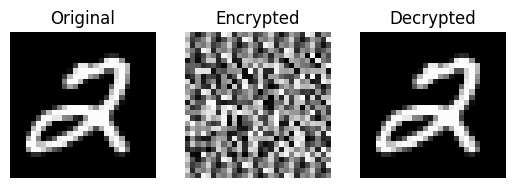

In [17]:
demods = tfds.load("mnist", split="test", batch_size=1)
demods = tfds.as_numpy(demods)
for batch in demods:
    batch = batch["image"][:, :, :, 0]
    encrypted = aes_encrypt(batch)
    decrypted = aes_decrypt(encrypted)
    plt.subplot(1, 3, 1, title="Original")
    plt.axis("off")
    plt.imshow(batch[0], cmap="gray", interpolation="nearest")
    plt.subplot(1, 3, 2, title="Encrypted")
    plt.axis("off")
    plt.imshow(encrypted[0], cmap="gray", interpolation="nearest")
    plt.subplot(1, 3, 3, title="Decrypted")
    plt.axis("off")
    plt.imshow(decrypted[0], cmap="gray", interpolation="nearest")
    plt.show()
    break

In [18]:
generator = load_model("generator.h5")
encoder = load_model("encoder.h5")
sign_swap = lambda x, k: x * np.sign(k)
vec_keygen = lambda: np.random.uniform(-1, 1, size=(100,))

In [19]:
def cpe_encrypt(images, e, k):
    return generator(e(encoder(images), k))

In [20]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=["accuracy"]
    )
    return discriminator

In [21]:
valds = tfds.load("mnist", split="train", batch_size=128)
valds = tfds.as_numpy(valds)

aes_disc = create_discriminator()
cpe_disc = create_discriminator()

def aes_enc_gen(ds):
    for b in ds:
        if len(b["image"]) < 128:
            continue
        b = b["image"][:, :, :, 0]
        aes_encrypted = aes_encrypt(b).astype(np.float32) / 127.5 - 1
        b = b.astype(np.float32) / 127.5 - 1
        b  = np.concatenate([b, aes_encrypted]).reshape((-1, 28, 28, 1))
        target = np.concatenate([np.ones((128, 1), dtype=np.float32), np.zeros((128, 1), dtype=np.float32)])
        yield b, target

def cpe_enc_gen(ds):
    for b in ds:
        if len(b["image"]) < 128:
            continue
        b = b["image"].astype(np.float32) / 127.5 - 1
        cpe_encrypted = cpe_encrypt(b, sign_swap, vec_keygen())
        b = np.concatenate([b, cpe_encrypted]).reshape((-1, 28, 28, 1))
        target = np.concatenate([np.ones((128, 1), dtype=np.float32), np.zeros((128, 1), dtype=np.float32)])
        yield b, target

aes_hist = aes_disc.fit(aes_enc_gen(valds), steps_per_epoch=1, epochs=400, verbose=0)
cpe_hist = cpe_disc.fit(cpe_enc_gen(valds), steps_per_epoch=1, epochs=400, verbose=0)

2023-08-15 17:20:22.281136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-15 17:20:27.356424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


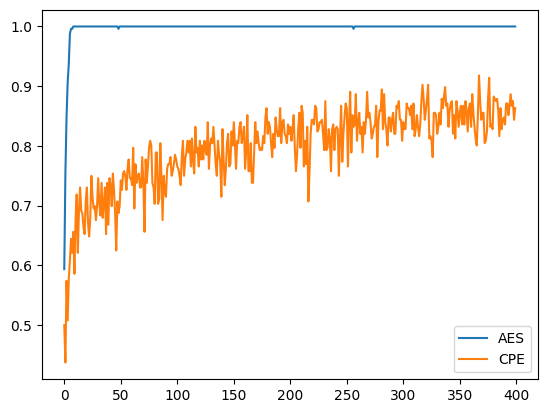

In [22]:
plt.plot(aes_hist.history["accuracy"], label="AES")
plt.plot(cpe_hist.history["accuracy"], label="CPE")
plt.legend()
plt.show()